**Chapter 06 – Processing Sequences Using RNNs and CNNs**

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'): # old method: tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

#def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#    print("Saving figure", fig_id)
#    if tight_layout:
#        plt.tight_layout()
#   plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNNs

## Forecasting a Time Series

Suppose we are studying the 
* number of active users per hour on your website, 
* or the daily temperature in your city, 
* or your company’s financial health, measured quarterly using multiple metrics. 


In all these cases, the data will be a sequence of one or more values per time step. This is called a ***time series***.


In the first two examples - 
* there is a single value per time step, so these are *univariate time series*, 
* while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a *multivariate time series*. 


A typical task is to predict future values, which is called ***forecasting***. 


Another common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past. This is called ***imputation***. 


For example, Figure 6 shows 3 univariate time series, each of them 50 time steps long, and the goal here is to **forecast** the value at the next time step (represented by the X) for each of them.

### Generate the Dataset
For simplicity, we are using a time series generated by the `generate_time_series()` function, shown here:

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # 4 different outputs of size [batch_size x 1]
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)  # numpy.newaxis is used to increase the dimension of the existing array by one more dimension

This function creates as many time series as requested (via the `batch_size` argument), each of length n_steps, and 

there is just one value per time step in each series (i.e., all series are **univariate**). 

The function returns a NumPy array of shape [batch size, time steps, 1], where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.

When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [*batch size, time steps, dimensionality*], where *dimensionality* is 1 for univariate time series and more for multivariate time series.

Now let’s create a training set, a validation set, and a test set using this function:

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

* `X_train` contains 7,000 time series (i.e., its shape is [7000, 50, 1]), 

* while `X_valid` contains 2,000 (from the 7,000th time series to the 8,999th) and 

* `X_test` contains 1,000 (from the 9,000th to the 9,999th). 

* Since we want to forecast a single value for each series, the targets are column vectors (e.g., `y_train` has a shape of [7000, 1]).

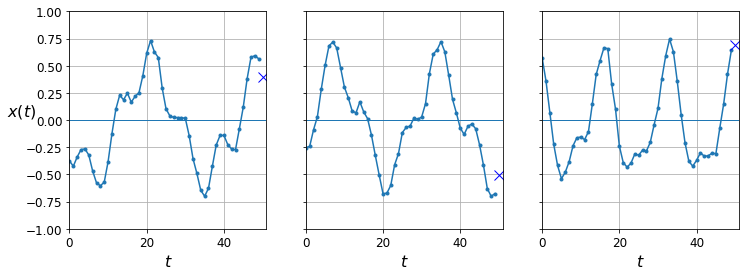

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
#save_fig("time_series_plot")
plt.show()

**Figure 6**: Time series forecasting.

### Computing Some Baselines

**Naive predictions** (just predict the last observed value):
* Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. 
* For example, the simplest approach is to predict the last value in each series. 
* This is called ***naive forecasting***, and it is sometimes surprisingly difficult to outperform. 

In this case, it gives us a mean squared error of about 0.020:

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

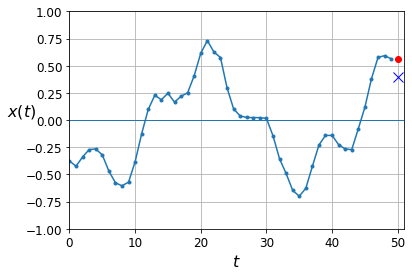

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Linear predictions**:
Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer. 
* Let us just use a **simple Linear Regression** model so that each prediction will be a linear combination of the values in the time series:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0063 - val_loss: 0.006

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0042


0.004168085753917694

In [11]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.0042


0.004241826944053173

As we 
* compiled this model using the MSE loss and the default Adam optimizer, 
* then fit it on the training set for 20 epochs and 
* evaluated it on the validation set, - 

we got an MSE of about 0.004. That’s much better than the naive approach!

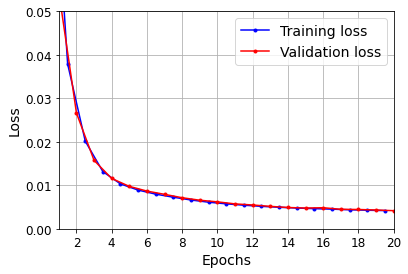

In [12]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

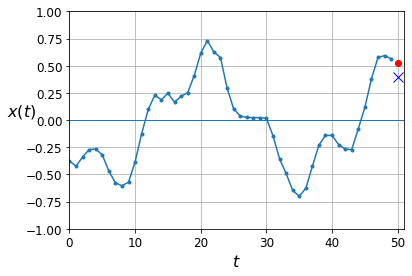

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN
Let us see if we can beat that with a simple RNN:

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 53s 237ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 55s 249ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 49s 225ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 52s 238ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 51s 232ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 70s 321ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 75s 343ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 76s 344ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 66s 301ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 69s 315ms/step - l

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 3s 42ms/step - loss: 0.0109


0.010881561785936356

In [17]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 1s 43ms/step - loss: 0.0113


0.011268764734268188

That is really the simplest RNN you can build. It just contains a single layer, with a single neuron, as we saw in Figure 1 (slide #4). 
* We **do not need to specify the length** of the input sequences (unlike in the previous model), since a recurrent neural network can process any number of time steps (this is why we set the first input dimension to None). 
* By default, the `SimpleRNN` layer uses the **hyperbolic tangent** activation function. 
* It works exactly as we saw earlier: 
    * the initial state h(init) is set to 0, and 
    * it is passed to a single recurrent neuron, along with the value of the first time step, x(0). 
    * The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result, and this gives the first output, y0. 
    * In a simple RNN, this output is also the new state h0. This new state is passed to the same recurrent neuron along with the next input value, x(1), and the process is repeated until the last time step. 
    * Then the layer just outputs the last value, y49. 
    
  All of this is performed simultaneously for every time series.
  

By default, recurrent layers in **Keras only return the final output**. 
* To make them return one output per time step, you must set `return_sequences=True`.

We find that its MSE reaches about 0.014, so it is better than the naive approach but it does not beat a simple linear model. 

* Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in the simple linear model we used, that’s a total of 51 parameters). 

* In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that’s just the number of recurrent neurons in the layer), plus a bias term. 

    * In this simple RNN, that’s a total of just three parameters.

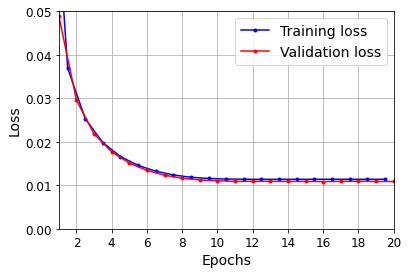

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

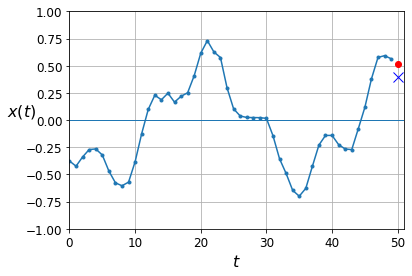

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

Apparently our simple RNN was too simple to get good performance. So let us try to add more recurrent layers!

It is quite common to stack multiple layers of cells, as shown in Figure 7. This gives you a deep RNN.

<img src="./images/Figure_07.png" width="500" border="1">

**Fig. 7**: Deep RNN (left) unrolled through time (right).

Implementing a deep RNN with tf.keras is quite simple: just stack recurrent layers. 
* In this example, we use three `SimpleRNN` layers (but we could add any other type of recurrent layer, such as an `LSTM` layer or a `GRU` layer, which we will discuss shortly):

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 192s 866ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 184s 840ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 181s 825ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 141s 643ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 175s 801ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 145s 663ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 127s 579ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 124s 567ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 125s 569ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 128s 583m

* Make sure to set `return_sequences=True` for all recurrent layers (except the last one, if we only care about the last output). 
* If we don’t, they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that we are not feeding it sequences in the expected 3D format.

We can use `keras.utils.plot_model()` to generate an image of our model:

* We will need to install graphviz and pydot  for `pydotprint` to work by running:
    * conda install graphviz, and
    * conda install pydot

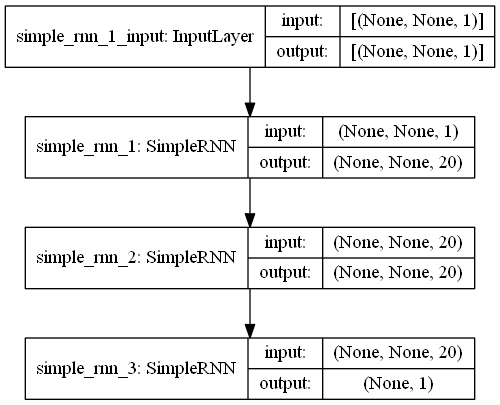

In [21]:
keras.utils.plot_model(model, "images/deepRNN_model.png", show_shapes=True)
# The "?" can also appear as "None" and vice versa.

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 6s 101ms/step - loss: 0.0029


0.0029105590656399727

In [24]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 3s 98ms/step - loss: 0.0030


0.0030340340454131365

The MSE is about 0.003. We finally managed to beat the linear model!

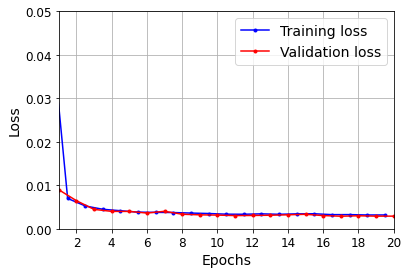

In [25]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

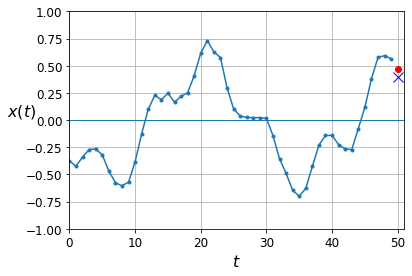

In [26]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output -

**Why?** 
* Note that the last layer is not ideal in previous setup: it must have a single unit because we want to forecast a univariate time series, and this means we must have a single output value per time step. 


* However, having a single unit means that the hidden state is just a single number. That’s really not much, and it’s probably not that useful; presumably, the RNN will mostly use the hidden states of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer’s hidden state very much. 


* Moreover, since a `SimpleRNN` layer uses the **tanh** activation function by default, the predicted values must lie within the range –1 to 1. But **what if you want to use another activation function?** For both these reasons, it might be preferable to **replace the output layer with a `Dense` layer**: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want. 


* If we make this change, also make sure to `remove return_sequences=True` from the second (now last) recurrent layer.


* If we train this model, we will see that it converges faster and performs just as well. Plus, we could change the output activation function if we wanted.

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 89s 397ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 86s 392ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 86s 391ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 86s 391ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 85s 390ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 88s 402ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 87s 398ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 86s 392ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 86s 391ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 86s 392ms/step - l

In [28]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 4s 67ms/step - loss: 0.0026


0.002623623702675104

In [29]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 2s 66ms/step - loss: 0.0028


0.0027615714352577925

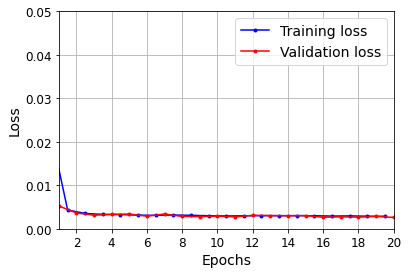

In [30]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

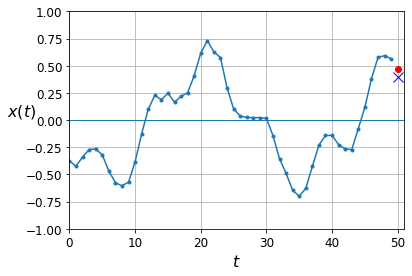

In [31]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

* So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict 10 steps ahead, just change the targets to be the value 10 steps ahead instead of 1 step ahead). 

* So, what if we want to predict the next 10 values?

The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the model again to predict the following value, and so on, as in the following code: 

In [32]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [33]:
Y_pred.shape

(1, 10, 1)

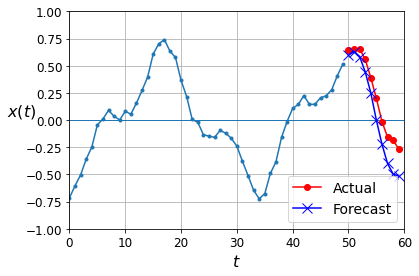

In [34]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
#save_fig("forecast_ahead_plot")
plt.show()

**Fig 8**: Forecasting 10 steps ahead, 1 step at a time.

As we might expect, the prediction for the next step will usually be **more accurate than the predictions for later** time steps, since the errors might accumulate (as we can see in Figure 8). 

* If we evaluate this approach on the validation set, we will find an MSE of about 0.029. This is much higher than the previous models, but it is also a much harder task, so the comparison does not mean much. 

* It’s much more meaningful to compare this performance with naive predictions (just forecasting that the time series will remain constant for 10 time steps) or with a simple linear model. 

* The naive approach is terrible (it gives an MSE of about 0.223), but the linear model gives an MSE of about 0.0188: 

    * it’s much better than using our RNN to forecast the future one step at a time, and also much faster to train and run. 
    * Still, if we only want to forecast a few time steps ahead, on more complex tasks, this approach may work well.

The *second option* is to train an RNN to predict all 10 next values at once. 
* We can still use a sequence-to-vector model, but it will output 10 values instead of 1. 
* However, we first need to change the targets to be vectors containing the next 10 values:

Now let us use this model to predict the next 10 values at once. We first need to regenerate the sequences with 10 values (or, 9 more time steps).

In [35]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let us predict the next 10 values one by one:

In [36]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [37]:
Y_pred.shape

(2000, 10)

In [38]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510846

Let us compare this performance with some baselines: naive predictions and a simple linear model:

In [39]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

Now we just need the output layer to have 10 units instead of 1:

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0300 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0278 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0262 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0228 - val_loss: 0.0222

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________


Now let's create an RNN that predicts all 10 next values at once:

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 88s 392ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 86s 393ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 86s 392ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 86s 391ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 87s 396ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 86s 393ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 86s 392ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 86s 391ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 86s 392ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 86s 391ms/step - l

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


After training this model, you can predict the next 10 values at once very easily:

In [44]:
Y_pred = model.predict(X_new)
Y_pred

array([[ 0.59747523,  0.5974007 ,  0.5398127 ,  0.44681242,  0.3182176 ,
         0.17894097,  0.0659737 , -0.00696872, -0.06230291, -0.11951049]],
      dtype=float32)

This model works nicely: the MSE for the next 10 time steps is about 0.008 (see the val_loss). 

* That’s much better than the linear model. 

But we can still do better: 
* indeed, instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values at each and every time step. 
    * In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. 
    * The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step. 
    * This means there will be many more error gradients flowing through the model, and they won’t have to flow only through time; they will also flow from the output of each time step. 
    * This will both stabilize and speed up training.

In [45]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

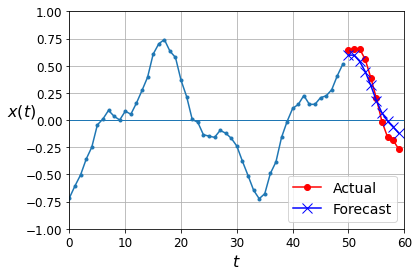

In [46]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let us create an RNN that predicts the next 10 steps at each time step. 
   * That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and 
   * finally it will forecast time steps 50 to 59 at the last time step. 
   
Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [47]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [48]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

To turn the model into a sequence-to-sequence model, we must set `return_sequences=True` in all recurrent layers (even the last one), and we must apply the output `Dense` layer at every time step. 

* Keras offers a `TimeDistributed` layer for this very purpose: it wraps any layer (e.g., a Dense layer) and applies it at every time step of its input sequence. 

* It does this efficiently, by reshaping the inputs so that each time step is treated as a separate instance (i.e., it reshapes the inputs from `[batch size, time steps, input dimensions]` to `[batch size × time steps, input dimensions]`; in this example, the number of input dimensions is 20 because the previous `SimpleRNN` layer has 20 units), 

* then it runs the `Dense` layer, and finally it reshapes the outputs back to sequences (i.e., it reshapes the outputs from `[batch size × time steps, output dimensions]` to `[batch size, time steps, output dimensions]`; In this example the number of output dimensions is 10, since the `Dense` layer has 10 units). Note that a `TimeDistributed(Dense(n))` layer is equivalent to a `Conv1D(n, filter_size=1)` layer.

Here is the updated model:

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

The `Dense` layer actually supports sequences as inputs (and even higher-dimensional inputs): 
* it handles them just like `TimeDistributed(Dense(…))`, meaning it is applied to the last input dimension only (independently across all time steps). 
* Thus, we could replace the last layer with just `Dense(10)`. 

For the sake of clarity, however, we will keep using `TimeDistributed(Dense(10))` because it makes it clear that the `Dense` layer is applied independently at each time step and that the model will output a sequence, not just a single vector.


All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation. 

So although we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, to only compute the MSE over the output at the last time step:

In [50]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 88s 395ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 86s 392ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0353 - val_last_time_step_mse: 0.0245
Epoch 3/20
219/219 [==============================] - 86s 393ms/step - loss: 0.0330 - last_time_step_mse: 0.0216 - val_loss: 0.0289 - val_last_time_step_mse: 0.0167
Epoch 4/20
219/219 [==============================] - 86s 392ms/step - loss: 0.0301 - last_time_step_mse: 0.0193 - val_loss: 0.0273 - val_last_time_step_mse: 0.0153
Epoch 5/20
219/219 [==============================] - 86s 392ms/step - loss: 0.0275 - last_time_step_mse: 0.0157 - val_loss: 0.0254 - val_last_time_step_mse: 0.0137
Epoch 6/20
219/219 [==============================] - 86s 392ms/step - loss: 0.0256 - last_time_step_mse: 0.0129 - val_loss: 0.0236 - val_last_time_step_mse: 0.0103
Epoch 7/20

In [51]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


We get a validation MSE of about 0.006, which is 25% better than the previous model. 

* We can combine this approach with the first one: just predict the next 10 values using this RNN, then concatenate these values to the input time series and use the model again to predict the next 10 values, and repeat the process as many times as needed. 

* With this approach, we can generate arbitrarily long sequences. 

* It may not be very accurate for long-term predictions, but it may be just fine if our goal is to generate original music or text, as we will see in the next chapter.

In [52]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

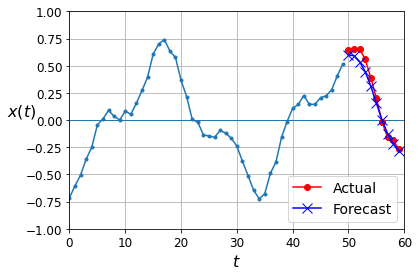

In [53]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

MC Dropout for confidence level:
When forecasting time series, it is often useful to have some error bars along with your predictions. 
* For this, an efficient technique is MC Dropout: 
    * add an MC Dropout layer within each memory cell, dropping part of the inputs and hidden states. 
    * After training, to forecast a new time series, use the model many times and compute the mean and standard deviation of the predictions at each time step.

# Fighting the Unstable Gradients Problem

### Deep RNN with Batch Norm

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 90s 401ms/step - loss: 0.4750 - last_time_step_mse: 0.5027 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 87s 399ms/step - loss: 0.0561 - last_time_step_mse: 0.0468 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 87s 398ms/step - loss: 0.0486 - last_time_step_mse: 0.0394 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 88s 401ms/step - loss: 0.0443 - last_time_step_mse: 0.0344 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 87s 399ms/step - loss: 0.0414 - last_time_step_mse: 0.0315 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 87s 399ms/step - loss: 0.0391 - last_time_step_mse: 0.0281 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20

In [55]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 20)          80        
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 20)          80        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          210       
Total params: 1,630
Trainable params: 1,550
Non-trainable params: 80
_________________________________________________________________


### Deep RNNs with Layer Norm

Let us use tf.keras to implement Layer Normalization within a simple memory cell. 

For this, we need to define a custom memory cell. It is just like a regular layer, except its call() method takes two arguments: 
* the inputs at the current time step and the hidden states from the previous time step. 
* Note that the states argument is a list containing one or more tensors. 
* In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an LSTMCell has a long-term state and a short-term state, as we will see shortly). 
* A cell must also have a `state_size` attribute and an `output_size` attribute. 
* In a simple RNN, both are simply equal to the number of units. 

The following code implements a custom memory cell which will behave like a `SimpleRNNCell`, except it will also apply Layer Normalization at each time step:

In [56]:
from tensorflow.keras.layers import LayerNormalization

In [57]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

The code is quite straightforward: 
* Our `LNSimpleRNNCell` class inherits from the `keras.layers.Layer` class, just like any custom layer. 
* The constructor takes the number of units and the desired activation function, and it sets the `state_size` and `output_size` attributes, then creates a `SimpleRNNCell` with no activation function (because we want to perform Layer Normalization after the linear operation but before the activation function). 
* Then the constructor creates the `LayerNormalization` layer, and finally it fetches the desired activation function. 
* The `call()` method starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a SimpleRNNCell, the outputs are just equal to the hidden states: 
    * in other words, `new_states[0]` is equal to outputs, so we can safely ignore `new_states` in the rest of the `call()` method). 
* Next, the `call()` method applies Layer Normalization, followed by the activation function. 
* Finally, it returns the outputs twice (once as the outputs, and once as the new hidden states). 

To use this custom cell, all we need to do is create a `keras.layers.RNN` layer, passing it a cell instance:

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 208s 930ms/step - loss: 0.2907 - last_time_step_mse: 0.2901 - val_loss: 0.0781 - val_last_time_step_mse: 0.0734
Epoch 2/20
219/219 [==============================] - 203s 926ms/step - loss: 0.0720 - last_time_step_mse: 0.0630 - val_loss: 0.0592 - val_last_time_step_mse: 0.0485
Epoch 3/20
219/219 [==============================] - 203s 928ms/step - loss: 0.0578 - last_time_step_mse: 0.0462 - val_loss: 0.0521 - val_last_time_step_mse: 0.0386
Epoch 4/20
219/219 [==============================] - 202s 924ms/step - loss: 0.0511 - last_time_step_mse: 0.0382 - val_loss: 0.0470 - val_last_time_step_mse: 0.0329
Epoch 5/20
219/219 [==============================] - 203s 925ms/step - loss: 0.0463 - last_time_step_mse: 0.0323 - val_loss: 0.0433 - val_last_time_step_mse: 0.0279
Epoch 6/20
219/219 [==============================] - 203s 928ms/step - loss: 0.0429 - last_time_step_mse: 0.0283 - val_loss: 0.0396 - val_last_time_step_mse: 0.0245
Epoc

In [59]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, None, 20)          480       
_________________________________________________________________
rnn_1 (RNN)                  (None, None, 20)          860       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 10)          210       
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________


Similarly, you could create a custom cell to apply dropout between each time step. But there is a simpler way: 
* all recurrent layers (except for `keras.layers.RNN`) and all cells provided by Keras have a `dropout` hyperparameter and a `recurrent_dropout` hyperparameter: 
    * the former defines the dropout rate to apply to the inputs (at each time step), and the latter defines the dropout rate for the hidden states (also at each time step). 
 * No need to create a custom cell to apply dropout at each time step in an RNN.
    
* With these techniques, you can alleviate the unstable gradients problem and train an RNN much more efficiently.

## Creating a Custom RNN Class

In [60]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 189s 855ms/step - loss: 0.3617 - last_time_step_mse: 0.3601 - val_loss: 0.0789 - val_last_time_step_mse: 0.0745
Epoch 2/20
219/219 [==============================] - 186s 850ms/step - loss: 0.0742 - last_time_step_mse: 0.0671 - val_loss: 0.0648 - val_last_time_step_mse: 0.0586
Epoch 3/20
219/219 [==============================] - 186s 849ms/step - loss: 0.0637 - last_time_step_mse: 0.0576 - val_loss: 0.0588 - val_last_time_step_mse: 0.0520
Epoch 4/20
219/219 [==============================] - 186s 851ms/step - loss: 0.0576 - last_time_step_mse: 0.0498 - val_loss: 0.0529 - val_last_time_step_mse: 0.0450
Epoch 5/20
219/219 [==============================] - 188s 860ms/step - loss: 0.0513 - last_time_step_mse: 0.0425 - val_loss: 0.0468 - val_last_time_step_mse: 0.0365
Epoch 6/20
219/219 [==============================] - 188s 856ms/step - loss: 0.0451 - last_time_step_mse: 0.0337 - val_loss: 0.0411 - val_last_time_step_mse: 0.0288
Epoc

In [62]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_rnn (MyRNN)               (None, None, 20)          480       
_________________________________________________________________
my_rnn_1 (MyRNN)             (None, None, 20)          860       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 10)          210       
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________


## LSTMs

In Keras, you can simply use the `LSTM` layer instead of the `SimpleRNN` layer:

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 10s 24ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 4s 21ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=

In [64]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788686841726303, 0.008560803718864918]

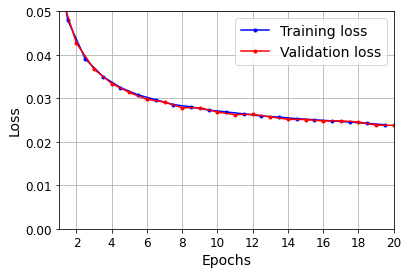

In [65]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [66]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

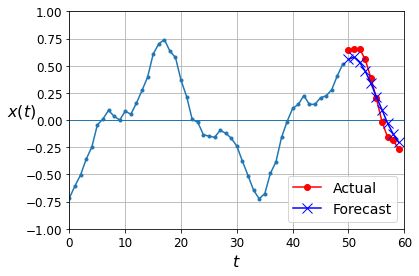

In [67]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Alternatively, you could use the general-purpose `keras.layers.RNN` layer, giving it an `LSTMCell` as an argument:

In [68]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [69]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_2 (RNN)                  (None, None, 20)          1760      
_________________________________________________________________
rnn_3 (RNN)                  (None, None, 20)          3280      
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


However, the LSTM layer uses an optimized implementation when running on a GPU, so in general it is preferable to use it (the RNN layer is mostly useful when you define custom cells, as we did earlier).

* In Keras, the LSTM layer is based on the `keras.layers.LSTMCell` cell, which does not support **peepholes**. 
* The experimental `tf.keras.experimental.PeepholeLSTMCell` does, however, so we can create a `keras.layers.RNN` layer and pass a `PeepholeLSTM` Cell to its constructor.

There are many other variants of the LSTM cell. One particularly popular variant is the GRU cell.

## GRUs

Keras provides a `keras.layers.GRU` layer (based on the `keras.layers.GRUCell` memory cell); using it is just a matter of replacing SimpleRNN or LSTM with GRU.

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 22ms/step - loss: 0.0995 - last_time_step_mse: 0.0940 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0495 - last_time_step_mse: 0.0383 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0432 - last_time_step_mse: 0.0321 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0379 - last_time_step_mse: 0.0261 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0333 - last_time_step_mse: 0.0192 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0310 - last_time_step_mse: 0.0158 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [==

In [71]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 10)          210       
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.02378549985587597, 0.0102628068998456]

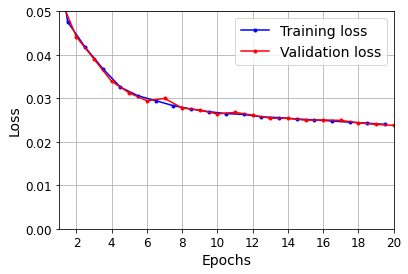

In [73]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [74]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

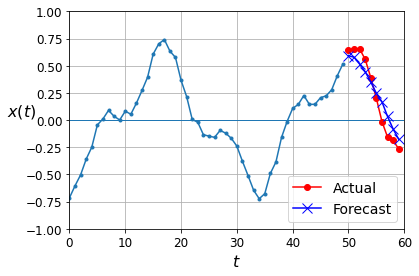

In [75]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using 1-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

If we train and evaluate this model, we will find that it is the best model so far. 
* The convolutional layer really helps. 
* In fact, it is actually possible to use only 1D convolutional layers and drop the recurrent layers entirely!

In [76]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 11s 22ms/step - loss: 0.0908 - last_time_step_mse: 0.0845 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0437 - last_time_step_mse: 0.0357 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0356 - last_time_step_mse: 0.0282 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0293 - last_time_step_mse: 0.0201 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0256 - last_time_step_mse: 0.0152 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0239 - last_time_step_mse: 0.0129 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [=

In [77]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          100       
_________________________________________________________________
gru_2 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
gru_3 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 10)          210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________


## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

Here is how to implement a simplified WaveNet to tackle the same sequences as earlier:

In [78]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 27ms/step - loss: 0.0981 - last_time_step_mse: 0.0890 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0339 - last_time_step_mse: 0.0211 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0291 - last_time_step_mse: 0.0164 - val_loss: 0.0270 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0265 - last_time_step_mse: 0.0141 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0251 - last_time_step_mse: 0.0128 - val_loss: 0.0244 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0242 - last_time_step_mse: 0.0122 - val_loss: 0.0232 - val_last_time_step_mse: 0.0107
Epoch 7/20
219/219 [==

In [79]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 20)          60        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 20)        

This `Sequential` model starts with an explicit input layer (this is simpler than trying to set `input_shape` only on the first layer), then continues with a 1D convolutional layer using `"causal"` padding: 
* this ensures that the convolutional layer does not peek into the future when making predictions (it is equivalent to padding the inputs with the right amount of zeros on the left and using `"valid"` padding). 
* We then add similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again 1, 2, 4, 8. 
* Finally, we add the output layer: 
    * a convolutional layer with 10 filters of size 1 and without any activation function. 
    * Due to the padding layers, every convolutional layer outputs a sequence of the same length as the input sequences, so the targets we use during training can be the full sequences: 
        * no need to crop them or downsample them.

Here is the original WaveNet defined in the paper: 
* it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [80]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [81]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [82]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [83]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 8s 27ms/step - loss: 0.1387 - last_time_step_mse: 0.1347 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 5s 23ms/step - loss: 0.1222 - last_time_step_mse: 0.1161 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189


In [84]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     96          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     4160        conv1d[0][0]                     
__________________________________________________________________________________________________
gated_activation_unit (GatedAct (None, None, 32)     0           conv1d_1[0][0]                   
______________________________________________________________________________________________

* In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. 

* In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). 

* We will also look at the Transformer, an Attention-only architecture.

END.